The data you provided is from the CoNLL-2003 dataset, which is used for Named Entity Recognition (NER) tasks. The dataset consists of sentences annotated with named entities such as persons, organizations, locations, and miscellaneous entities. Each line in the dataset represents a token (word or punctuation) along with its Part-of-Speech (POS) tag, chunk tag, and named entity tag.

##### Here's a breakdown of the data format:
Each line contains four columns separated by spaces:
- Token (word or punctuation)
- POS tag (Part-of-Speech tag)
- Chunk tag (syntactic chunk tag)
- Named entity tag (the target label for NER)
- Sentences are separated by blank lines.

- The "-DOCSTART-" line indicates the beginning of a new document in the dataset.

##### Example:
- **EU NNP B-NP B-ORG:**
	"EU" is the token, "NNP" is its POS tag (proper noun), "B-NP" is the chunk tag (beginning of a noun phrase), and "B-ORG" is the named entity tag (beginning of an organization entity).

### Reading The Data

In [1]:
import os

def load_data(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
        

    sentences, labels = [], []
    sentence, label = [], []

    for line in lines:
        if line == "\n" or line.startswith("-DOCSTART-"):
            if sentence and label:
                sentences.append(sentence)
                labels.append(label)
                sentence, label = [], []
        else:
            word, _, _, tag = line.strip().split()
            sentence.append(word.lower())  # Normalize the case
            label.append(tag)

    return sentences, labels

train_file_path = "/kaggle/input/conll-2003/data/conllpp_train.txt"
test_file_path = "/kaggle/input/conll-2003/data/conllpp_test.txt"

train_sentences, train_labels = load_data(train_file_path)
test_sentences, test_labels = load_data(test_file_path)

In [2]:
!ls /kaggle/input/conll-2003/data

conllpp_dev.txt  conllpp_test.txt  conllpp_train.txt


### Showing the table

In [3]:
import pandas as pd

df = pd.DataFrame({
    "train_sentences":train_sentences,
    "train_labels":train_labels
})
df

,train_sentences,train_labels
0,"[eu, rejects, german, call, to, boycott, briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,"[peter, blackburn]","[B-PER, I-PER]"
2,"[brussels, 1996-08-22]","[B-LOC, O]"
3,"[the, european, commission, said, on, thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,"[germany, 's, representative, to, the, europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."
...,...,...
14036,"[on, friday, :]","[O, O, O]"
14037,"[division, two]","[O, O]"
14038,"[plymouth, 2, preston, 1]","[B-ORG, O, B-ORG, O]"
14039,"[division, three]","[O, O]"


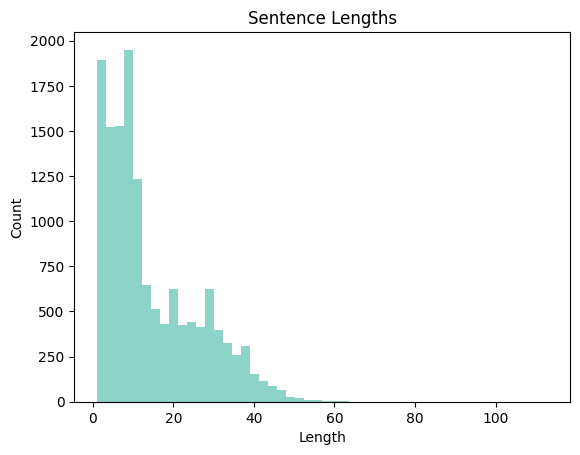

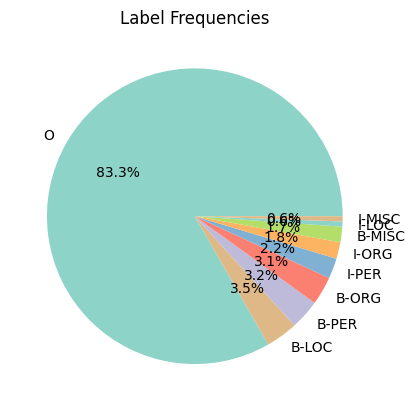

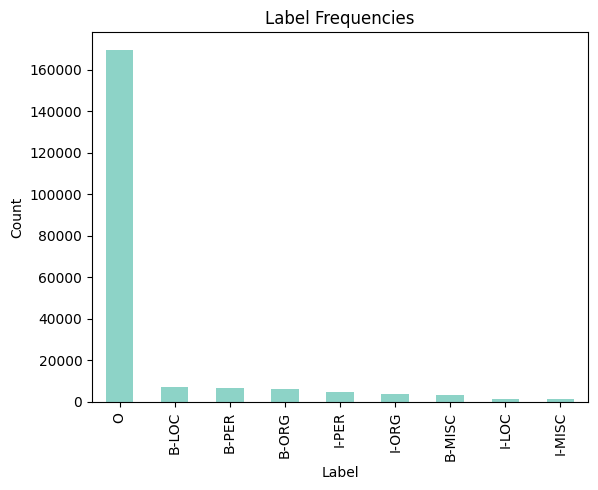

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a histogram of the sentence lengths
sentence_lengths = [len(sentence) for sentence in df['train_sentences']]
plt.hist(sentence_lengths, bins=50, color ='#8dd3c7' )
plt.title('Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

# Plot a pie chart of the label frequencies
label_counts = df['train_labels'].explode().value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors= ['#8dd3c7', 'burlywood', '#bebada', '#fb8072', 
           '#80b1d3', '#fdb462', '#b3de69'])
plt.title('Label Frequencies')
plt.show()

# Plot a bar chart of the label frequencies
label_counts.plot(kind='bar', color = '#8dd3c7' )
plt.title('Label Frequencies')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Tokenize & add some padding to sentences/labels

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

# Tokenize sentences
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_sentences)
train_sequences = word_tokenizer.texts_to_sequences(train_sentences)
test_sequences = word_tokenizer.texts_to_sequences(test_sentences)

# Pad sentences
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Tokenize labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)
train_label_sequences = label_tokenizer.texts_to_sequences(train_labels)
test_label_sequences = label_tokenizer.texts_to_sequences(test_labels)

# Pad labels
y_train = pad_sequences(train_label_sequences, maxlen=max_len)
y_test = pad_sequences(test_label_sequences, maxlen=max_len)

2024-05-06 11:00:34.799332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:00:34.799454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:00:34.959431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Build & Train the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

vocab_size = len(word_tokenizer.word_index) + 1

embedding_dim = 100
hidden_units = 64
num_classes = len(label_tokenizer.word_index) + 1
batch_size = 32
num_epochs = 10

# Création du modèle
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True)))
model.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# Entraînement du modèle
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9120 - loss: 0.3615 - val_accuracy: 0.9346 - val_loss: 0.4626
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9843 - loss: 0.0593 - val_accuracy: 0.9364 - val_loss: 0.5255
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9939 - loss: 0.0238 - val_accuracy: 0.9371 - val_loss: 0.5761
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9964 - loss: 0.0139 - val_accuracy: 0.9373 - val_loss: 0.6078
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9978 - loss: 0.0087 - val_accuracy: 0.9373 - val_loss: 0.6396
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9363 - val_loss: 0.6686
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9371 - val_loss: 0.7000
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     2,101,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 10)         │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,560,312 (25.03 MB)

 Trainable params: 2,186,770 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,373,542 (16.68 MB)

In [9]:
from tensorflow.keras.layers import BatchNormalization, Dropout

embedding_dim = 256
hidden_units = 100
num_classes = len(label_tokenizer.word_index) + 1
batch_size = 128
num_epochs = 20

# Création du modèle
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(units=hidden_units, return_sequences=True, dropout=0.2)))
model2.add(BatchNormalization())
model2.add(Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2)))
model2.add(BatchNormalization())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(num_classes, activation='softmax'))

# Compilation du modèle
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
# Entraînement du modèle
history2 = model2.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.9036 - loss: 0.3809 - val_accuracy: 0.8913 - val_loss: 0.6060
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.9832 - loss: 0.0567 - val_accuracy: 0.9238 - val_loss: 0.4040
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.9951 - loss: 0.0171 - val_accuracy: 0.9337 - val_loss: 0.3898
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9972 - loss: 0.0095 - val_accuracy: 0.9363 - val_loss: 0.5088
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9375 - val_loss: 0.6446
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9986 - loss: 0.0043 - val_accuracy: 0.9369 - val_loss: 0.7575
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9369 - val_loss: 0.8186
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.9991 - loss: 0

In [11]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 256)        │     5,378,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 200)        │       285,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 200)        │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 128)        │       135,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 1024)       │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50, 10)         │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,829,184 (68.01 MB)

 Trainable params: 5,942,842 (22.67 MB)

 Non-trainable params: 656 (2.56 KB)

 Optimizer params: 11,885,686 (45.34 MB)

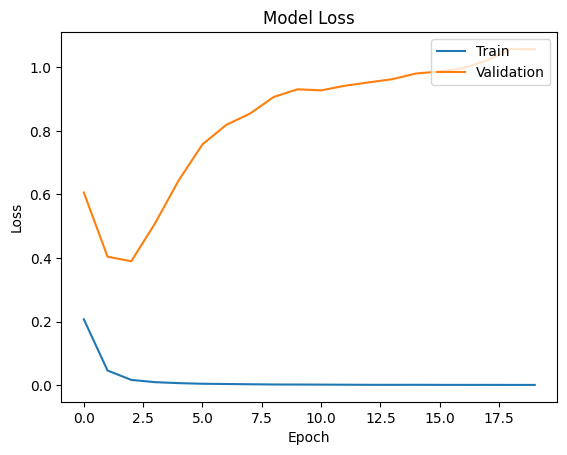

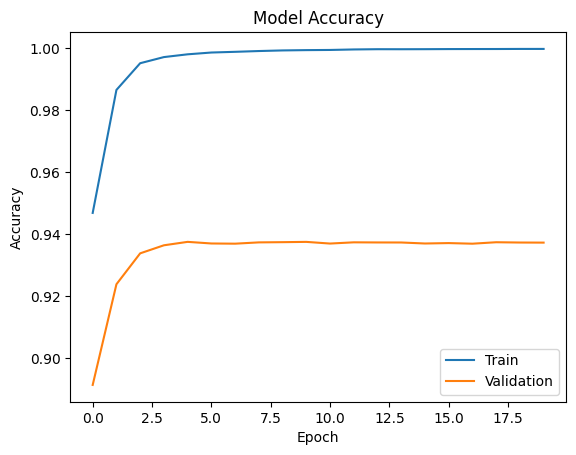

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

### Model evaluation

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict labels for test data
y_pred = model2.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

# Convert label sequences back to text labels
y_test_labels = label_tokenizer.sequences_to_texts(y_test)
y_pred_labels = label_tokenizer.sequences_to_texts(y_pred)

# Calculate token-level metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Calculate entity-level metrics
report = classification_report(y_test_labels, y_pred_labels)

print("Token-level metrics:")
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWa

Token-level metrics:
Accuracy: 0.29
Precision: 0.33
Recall: 0.29
F1-score: 0.30


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
